In [193]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle

In [194]:
def plot_ddos(df: pd.DataFrame):
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    # Create a figure
    fig = plt.figure(figsize=(25,15))
    # Add a subplot
    ax = fig.add_subplot()

    ax.plot(xAxis, yAxis)
    rect = Rectangle((7200, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    rect = Rectangle((3600*3 + 7200 +280, 0), 300, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    plt.ylabel('Label')
    plt.xlabel('Minute')
    plt.title('Network Traffic')
    plt.show()

In [195]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    veriseti = pd.read_csv(path, low_memory=False)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

data_path = '../verisetleri/ddos_dataset_on_seconds.csv'
df = upload_dataset_with_time(data_path)

Dataset is loaded in 0.11157925000043178 seconds


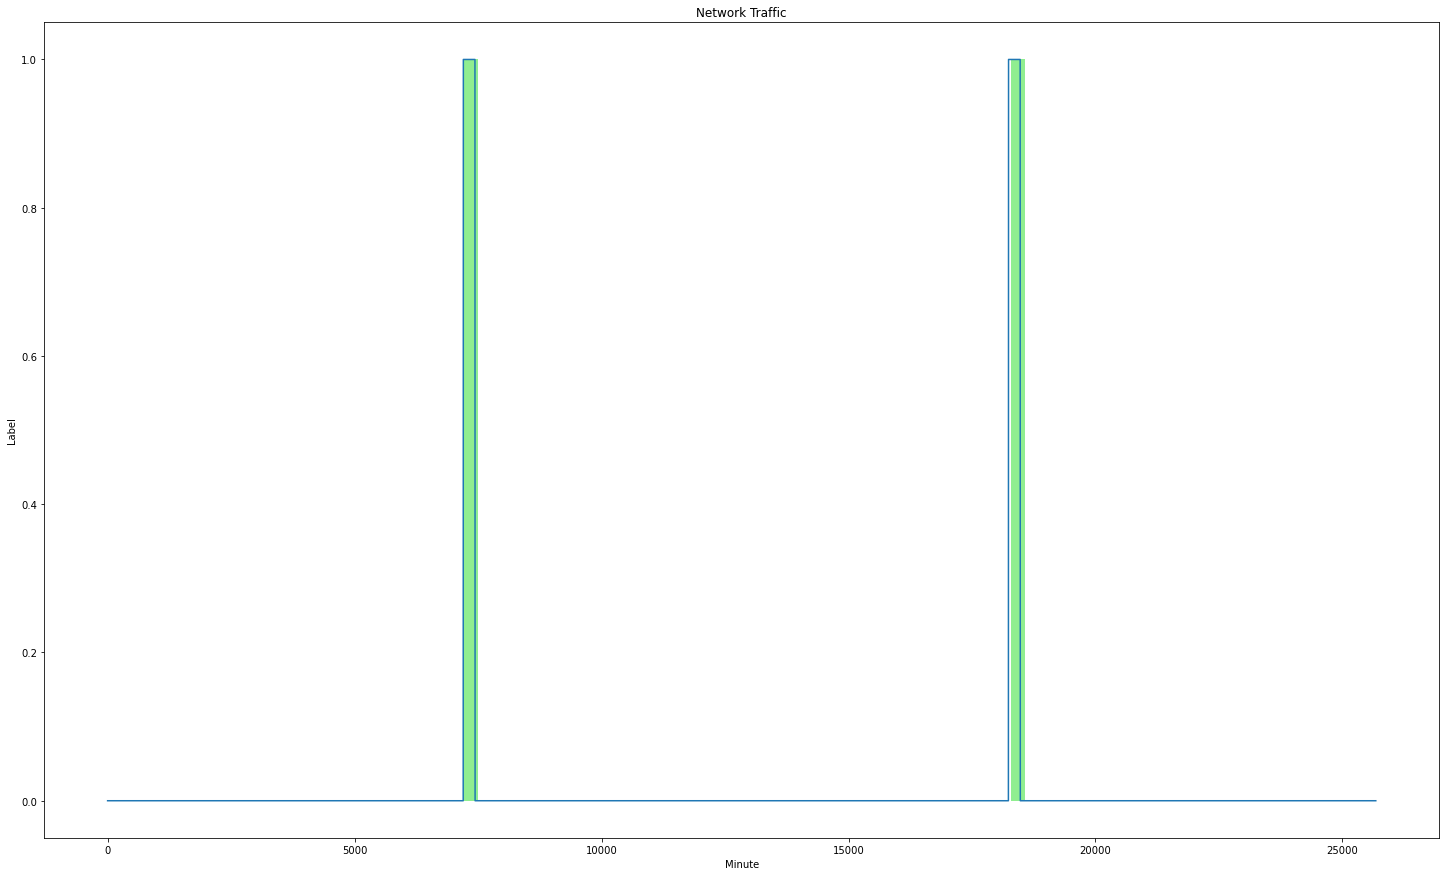

In [196]:
plot_ddos(df.copy())

In [197]:
def select_samples_from_dataset(dataset : pd.DataFrame , samples : list):
    if (dataset.empty):
        raise ValueError("Dataset is None!")

    if (samples == None):
        raise ValueError("sample list is None")

    return dataset.iloc[samples, :]

In [198]:
from sklearn.metrics import classification_report
def calculate_classification_report(y_values_df : pd.DataFrame):
    if 'y_true' not in y_values_df.columns:
        raise ValueError('true vals not included in df')

    if 'y_pred' not in y_values_df.columns:
        raise ValueError('pred vals not included in df')

    return classification_report(y_values_df["y_true"].to_list(), y_values_df["y_pred"].to_list(), output_dict=True)["1"]

In [199]:
def obtain_y_vals(dataframe:pd.DataFrame, selected_label_list):
    df_idxs = list(range(0, len(dataframe)))
    for idx in selected_label_list:
        df_idxs.remove(idx)
    
    pred_df = pd.DataFrame()
    pred_df['y_true'] = dataframe["Label"].copy()
    pred_df["y_pred"] = dataframe["Label"].copy()
    
    pred_df.iloc[df_idxs, 0] = 0
    pred_df.iloc[selected_label_list, 0] = 1
    return pred_df

In [200]:
import stumpy
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 4

In [201]:
y = df[["Label"]]
X = df.drop(["Label"], axis = 1)

In [202]:
feature_map = {i : feat_name for i, feat_name in enumerate(X.columns)}
X.columns = list(range(0, len(X.columns)))

In [203]:
featureNumber = 5
genes = [random.randrange(0,2) for _ in range(featureNumber)]
gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
individual = X.iloc[:, gene_indexes]

In [204]:
window_size = 60
curr_mps, curr_indices = stumpy.mstump(individual, window_size)

KeyboardInterrupt: 

In [ ]:
#ileride sadece discord base mp_maximization kullanirsak ise yarayabilir.
mp_mp = mp.compute(individual[1].to_list(),windows=60, n_jobs=4)
mp_mps, mp_pi = mp_mp['mp'], mp_mp['pi']
sorted_list = sorted(zip(mp_pi, mp_mps), key=lambda x:x[1], reverse=True)[:3]

In [ ]:
individual

,1,3
0,72193.0,138620706.0
1,36679.0,15398436.0
2,31317.0,12264572.0
3,72193.0,138620706.0
4,36679.0,15398436.0
...,...,...
25671,36679.0,15398436.0
25672,31317.0,12264572.0
25673,72193.0,138620706.0
25674,36679.0,15398436.0


In [ ]:
curr_mps.shape

(2, 25617)

In [ ]:
individual

,1,3
0,72193.0,138620706.0
1,36679.0,15398436.0
2,31317.0,12264572.0
3,72193.0,138620706.0
4,36679.0,15398436.0
...,...,...
25671,36679.0,15398436.0
25672,31317.0,12264572.0
25673,72193.0,138620706.0
25674,36679.0,15398436.0


In [ ]:
def calculate_discords(mps: np.array, individual:pd.DataFrame, window_size:int, discord_num:int=476):
    from collections import Counter
    curr_mps_dict = dict()
    curr_mps_dict = {f_idx: np.argsort(curr_mps[idx])[::-1][:500] for idx, f_idx in enumerate(individual.columns)}
    discords = {}
    for idx, indices in curr_mps_dict.items():
        print(f'now processing current idx: {idx}') 
        indice_list = []
        for indice in indices:
            #get mp point window
            indice_list.extend(list(range(indice, indice + window_size - 1)))
        #sort the indices by count
        sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
        sorted_discord_indexes = [elem[0] for elem in sorted_discords[:discord_num]]

        discords[idx] = sorted_discord_indexes
    return discords
        

In [ ]:
def majority_vote_discords(discord_dict: dict, discord_number:int = 476):
    from collections import Counter
    overall_list = []
    for ft, ids_list in discord_dict.items():
        overall_list.extend(ids_list.copy())

    sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
    overall_ids = [elem[0] for elem in sorted_overall[:discord_number]]

    return overall_ids

In [ ]:
discord_dict = calculate_discords(curr_mps, individual.copy(), window_size=window_size, discord_num=476)

now processing current idx: 0
now processing current idx: 2


In [ ]:
discords = majority_vote_discords(discord_dict=discord_dict, discord_number=476)

In [ ]:
y_vals = obtain_y_vals(df.copy(), discords)

In [ ]:
calculate_classification_report(y_vals)['f1-score']

0.8424369747899161

In [296]:
class MatrixProfileManager:
    if 'global_df' not in dir():
        global_df = pd.read_csv('../verisetleri/ddos_dataset_on_seconds.csv', low_memory=True)

    def __init__(self, df:pd.DataFrame, window_size:int = 60, discord_number = 476, method='mpx', measure='acc'):
        self.measurement = measure
        self.window_size = window_size
        self.discord_number = discord_number
        self.discord_dict = {}
        self.discords = []
        self.df = df
        self.mp_method = method
        self.curr_mp_dict = {}

    def calculate_mp_multivariate_stumpy(self):
        curr_mps, curr_indices = stumpy.mstump(self.df, self.window_size)
        self.mps = curr_mps

    def calculate_mp_seperately_mpx(self):
        import matrixprofile as mp
        mp_list = []
        for ft in self.df.columns:
            inputSignal = self.df[ft].to_list()
            matrix_profile = mp.compute(inputSignal, windows=self.window_size, threshold=0.95, n_jobs=4)
            mp_list.append(matrix_profile['mp'])

        self.mps = np.array(mp_list)
    
    def calculate_discords(self):
        from collections import Counter
        curr_mps_dict = dict()
        curr_mps_dict = {f_idx: np.argsort(self.mps[idx])[::-1][:500] for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:self.discord_number] for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            # print(f'now processing current idx: {idx}') 
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))
            #sort the indices by count
            sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
            sorted_discord_indexes = [elem[0] for elem in sorted_discords[:self.discord_number]]

            self.discord_dict[idx] = sorted_discord_indexes

    def majority_vote_discords(self):
        from collections import Counter
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list.copy())

        sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
        self.discords = [elem[0] for elem in sorted_overall[:self.discord_number]]

    def obtain_y_vals(self):
        df_idxs = list(range(0, len(MatrixProfileManager.global_df)))
        for idx in self.discords:
            df_idxs.remove(idx)
        
        self.pred_df = pd.DataFrame()
        self.pred_df['y_true'] = MatrixProfileManager.global_df["Label"].copy()
        self.pred_df["y_pred"] = MatrixProfileManager.global_df["Label"].copy()
        
        self.pred_df.iloc[df_idxs, 0] = 0
        self.pred_df.iloc[self.discords, 0] = 1

    def calculate_classification_report(self):
        from sklearn.metrics import classification_report
        if 'y_true' not in self.pred_df.columns:
            raise ValueError('true vals not included in df')

        if 'y_pred' not in self.pred_df.columns:
            raise ValueError('pred vals not included in df')

        self.creport = classification_report(self.pred_df["y_true"].to_list(),
                                             self.pred_df["y_pred"].to_list(), output_dict=True)["1"]

    def get_f1_score(self):
        if self.creport is None:
            raise ValueError('Classification Report is not ready!')
            
        return self.creport['f1-score']

    def get_mp_score(self):
        #maximize this
        return sum([sum(mp_score) for mp_score in self.curr_mp_dict.values()]) / len(self.curr_mp_dict.keys())

    def calculate_cost(self):
        if self.mp_method.lower() == 'mpx':
            self.calculate_mp_seperately_mpx()
        else:
            self.calculate_mp_multivariate_stumpy()
        
        self.calculate_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()
        if self.measurement == 'acc':
            return self.get_f1_score()
        else:
            return self.get_mp_score()
                

In [306]:
class GeneticAlgo:
    def __init__(self, df:pd.DataFrame, max_features:int, population_bag_size:int = 3):
        print('Genetic Algorithm Process is ready to start')
        self.df = df.copy()
        self.y = df[["Label"]]
        self.X = df.drop(["Label"], axis = 1)
        self.feature_map = {i : feat_name for i, feat_name in enumerate(X.columns)}
        self.X.columns = list(range(0, len(X.columns)))
        self.feature_number = max_features
        self.pop_bag_size = population_bag_size
        self.creport = None
        

    def initialize_population(self):
        self.population_bag = []
        for _ in range(self.pop_bag_size):
            #0 veya 1 atiyoruz feature pick or not pick, 1 olanlari appendliyoruz.
            genes = [random.randrange(0,2) for _ in range(self.feature_number)]
            gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
            if (len(gene_indexes) == 0):
                gene_indexes.append(random.randint(1,self.feature_number))

            self.population_bag.append(X.iloc[:, gene_indexes])

        return self.population_bag

    def fitness_function(self, individual:pd.DataFrame):
        mp_manager = MatrixProfileManager(individual.copy(), window_size=60, discord_number=476, method='mpx', measure='mp')
        cost = mp_manager.calculate_cost()
        print(f'processing solution: {individual.columns.to_list()}')
        print(f"f1-score is: {mp_manager.get_f1_score()}")
        return cost

    def eval_fit_population(self, pop_bag):
        #This evaluation is based on minimizing the cost!
        result = {}
        fit_vals_lst = []
        solutions = []
        for individual in pop_bag:
            if (type(individual) != pd.DataFrame):
                assert(True)

            fit_vals_lst.append(self.fitness_function(individual))
            solutions.append(individual.columns.to_list())
            
        result["fit_vals"] = fit_vals_lst
        min_wgh = [abs(np.min(list(result['fit_vals'])) - i) for i in list(result['fit_vals'])]
        result["fit_wgh"]  = [i/sum(min_wgh) for i in min_wgh]
        result["solution"] = np.array(solutions, dtype=list)
        return result

    def find_best(self, eval_result:dict)->dict:
        # Best individual so far
        best_fit = np.max(eval_result["fit_vals"])
        best_fit_index = eval_result["fit_vals"].index(best_fit)
        best_solution  = eval_result["solution"][best_fit_index]
        print(f'best fit: {best_fit}\nsolution:{best_solution}')
        return {'best_fit': best_fit, 'index' : best_fit_index, 'solution': best_solution}

In [307]:
genetic_algo = GeneticAlgo(df.copy(), max_features=4, population_bag_size=5)
initial_population = genetic_algo.initialize_population()

Genetic Algorithm Process is ready to start


In [308]:
res = genetic_algo.eval_fit_population(initial_population)
genetic_algo.find_best(res)

processing solution: [1, 3]
f1-score is: 0.8865546218487395
processing solution: [1]
f1-score is: 0.8865546218487395
processing solution: [0, 1, 2, 3]
f1-score is: 0.9915966386554622
processing solution: [0, 2]
f1-score is: 0.9117647058823528
processing solution: [1]
f1-score is: 0.8865546218487395
best fit: 0.26454249236428157
solution:[1, 3]


{'best_fit': 0.26454249236428157, 'index': 0, 'solution': [1, 3]}

In [284]:
g = 0
if g == 0:
    best_fit_global      = best_fit
    best_solution_global = best_solution
else:
    if best_fit <= best_fit_global:
        best_fit_global      = best_fit
        best_solution_global = best_solution

In [286]:
best_solution_global

[3]

In [ ]:
result = {}
fit_vals_lst = []
solutions = []
for solution in self.population_bag:
    fit_vals_lst.append(self.fitness_function(solution))
    solutions.append(solution)
result["fit_vals"] = fit_vals_lst
min_wgh = [np.max(list(result["fit_vals"]))-i for i in list(result["fit_vals"])]
    result["fit_wgh"]  = [i/sum(min_wgh) for i in min_wgh]
    result["solution"] = np.array(solutions)